<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/evaluation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performance Evaluation Tutorial
By Fayyaz Minhas


Performance evaluation is a critical step in the machine learning pipeline. It allows us to understand how well a model generalizes to unseen data, how to compare different models, and how to choose the best one for deployment. This tutorial guides you through key evaluation techniques while walking through an example dataset and classifier.

## Data Generation

Before we dive into model evaluation, let’s generate a synthetic dataset to illustrate key concepts. For this we will simulate a data generation process using the function below which gives a balanced dataset with equal numbers of positive and negative examples.

In [1]:
from numpy.random import randn
import numpy as np

class DataStreamGenerator:
    """
    A data generator class that produces one example at a time
    with a fixed proportion of positive and negative examples.
    """
    def __init__(self, pos_ratio=0.5, d=2, random_seed=None):
        """
        Initialize the data stream generator.

        Parameters:
        - pos_ratio (float): Proportion of positive examples (0.0 to 1.0).
        - d (int): Dimensionality of the data (number of features).
        - random_seed (int or None): Random seed for reproducibility.
        """
        assert 0 <= pos_ratio <= 1, "pos_ratio must be between 0 and 1."
        self.pos_ratio = pos_ratio
        self.d = d
        self.random_seed = random_seed
        if random_seed is not None:
            np.random.seed(random_seed)

    def generate_example(self):
        """
        Generate a single example (one data point).

        Returns:
        - x (numpy.ndarray): Feature vector of shape (d,).
        - y (int): Label (+1 for positive, -1 for negative).
        """
        if np.random.rand() < self.pos_ratio:
            # Generate a positive example
            x = randn(self.d) + 1
            y = +1
        else:
            # Generate a negative example from one of two clusters
            if np.random.rand() < 0.5:
                x = randn(self.d) - 1  # Cluster 1
            else:
                x = randn(self.d) + 2  # Cluster 2
            y = -1
        return x, y

    def generate_batch(self, n):
        """
        Generate a batch of examples.

        Parameters:
        - n (int): Number of examples to generate.

        Returns:
        - X (numpy.ndarray): Feature matrix of shape (n, d).
        - Y (numpy.ndarray): Labels array of shape (n,).
        """
        X, Y = [], []
        for _ in range(n):
            x, y = self.generate_example()
            X.append(x)
            Y.append(y)
        return np.array(X), np.array(Y)

    def __repr__(self):
        """
        Representation of the DataStreamGenerator object.
        """
        return (f"DataStreamGenerator(pos_ratio={self.pos_ratio}, "
                f"d={self.d}, random_seed={self.random_seed})")


## 2. Visualizing the Data and Classifier Boundaries

Visualizing the dataset and decision boundaries helps us intuitively understand model behavior.

### Plotting Data and Decision Boundaries
The plotit function allows us to visualize 2D data points, class labels, and decision boundaries of a classifier.

In [2]:
from numpy.random import randn #importing randn
import numpy as np #importing numpy
import matplotlib.pyplot as plt #importing plotting module
import itertools
import warnings

def plotit(X,Y=None,clf=None,  conts = None, ccolors = ('b','k','r'), colors = ('c','y'), markers = ('s','o'), hold = False, transform = None,extent = None,**kwargs):
    """
    A function for showing data scatter plot and classification boundary
    of a classifier for 2D data
        X: nxd  matrix of data points
        Y: (optional) n vector of class labels
        clf: (optional) classification/discriminant function handle
        conts: (optional) contours (if None, contours are drawn for each class boundary)
        ccolors: (optional) colors for contours
        colors: (optional) colors for each class (sorted wrt class id)
            can be 'scaled' or 'random' or a list/tuple of color ids
        markers: (optional) markers for each class (sorted wrt class id)
        hold: Whether to hold the plot or not for overlay (default: False).
        transform: (optional) a function handle for transforming data before passing to clf
        kwargs: any keyword arguments to be passed to clf (if any)
    """
    if clf is not None and X.shape[1]!=2:
        warnings.warn("Data Dimensionality is not 2. Unable to plot.")
        return
    if markers is None:
        markers = ('.',)
    eps=1e-6
    d0,d1 = (0,1)
    if extent is None:
        minx, maxx = np.min(X[:,d0])-eps, np.max(X[:,d0])+eps
        miny, maxy = np.min(X[:,d1])-eps, np.max(X[:,d1])+eps
        extent = [minx,maxx,miny,maxy]
    else:
        [minx,maxx,miny,maxy] = extent
    if Y is not None:
        classes = sorted(set(Y))
        if conts is None:
            conts = list(classes)
        vmin,vmax = classes[0]-eps,classes[-1]+eps
    else:
        vmin,vmax=-2-eps,2+eps
        if conts is None:
            conts = sorted([-1+eps,0,1-eps])

    if clf is not None:
        npts = 150
        x = np.linspace(minx,maxx,npts)
        y = np.linspace(miny,maxy,npts)
        t = np.array(list(itertools.product(x,y)))
        if transform is not None:
            t = transform(t)
        z = clf(t,**kwargs)

        z = np.reshape(z,(npts,npts)).T


        plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')
        #plt.imshow(np.flipud(z), extent = extent, cmap=plt.cm.Purples, vmin = -2, vmax = +2); plt.colorbar()
        plt.pcolormesh(x, y, z,cmap=plt.cm.Purples,vmin=vmin,vmax=vmax);plt.colorbar()
        plt.axis(extent)

    if Y is not None:
        for i,y in enumerate(classes):
            if colors is None or colors=='scaled':
                cc = np.array([[i,i,i]])/float(len(classes))
            elif colors =='random':
                cc = np.array([[np.random.rand(),np.random.rand(),np.random.rand()]])
            else:
                cc = colors[i%len(colors)]
            mm = markers[i%len(markers)]
            plt.scatter(X[Y==y,d0],X[Y==y,d1], marker = mm,c = cc, s = 30)

    else:
        plt.scatter(X[:,d0],X[:,d1],marker = markers[0], c = 'k', s = 5)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    if not hold:
        plt.grid()
        plt.show()
    return extent

### Example Visualization



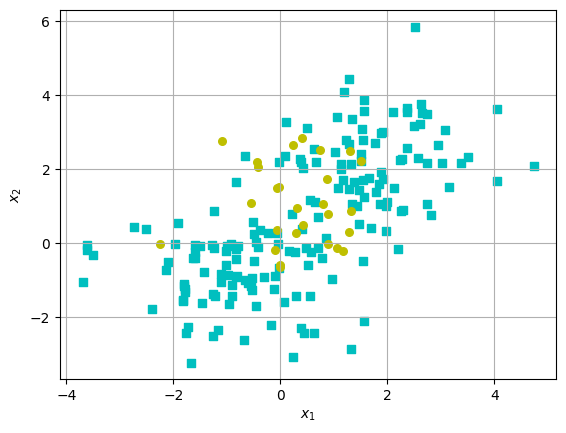

[-3.696887642941572, 4.734423159061742, -3.230330907625889, 5.852732490654721]

In [3]:
# Create a data stream generator with 50% positive examples
stream_gen = DataStreamGenerator(pos_ratio=0.1, d=2, random_seed=42)
# Generate a batch of 10 examples
X, Y = stream_gen.generate_batch(200)
plotit(X,Y)

## 3. Splitting Data: Training, Validation, and Testing
Understanding the roles of different datasets is crucial:

* Training Set: Used to fit the model.

* Validation Set: Helps tune hyperparameters and prevent overfitting.

* Test Set: Evaluates final model performance on unseen data.

Key Insight: Keeping these datasets separate ensures unbiased evaluation.

Here we divide the given set into a training set and a validation set. For the testing, we will generate data later.



In [4]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle=True)


### 4. Evaluating Model Performance
Let’s train a Support Vector Machine (SVM) and evaluate its performance.

In [5]:
from sklearn.svm import SVC
clf = SVC(C=10.0, kernel='rbf', gamma=1.0)
clf.fit(X_train, y_train)


SVC(C=10.0, gamma=1.0)

### Metrics for Evaluation
Key metrics for a classification problem include:

* Accuracy: Percentage of correct predictions.
* Precision: Proportion of true positives among predicted positives.
* Recall (TPR): Proportion of true positives among actual positives.
* False Positive Rate (FPR): Proportion of false positives among actual negatives.

Below, we calculate them at a threshold of 0.0.



In [6]:
threshold = 0.0
z_val = clf.decision_function(X_val)
predictions = 2 * (z_val > threshold) - 1
accuracy = np.mean(predictions == y_val)
tpr = np.sum((predictions == 1) & (y_val == 1)) / np.sum(y_val == 1)
fpr = np.mean((predictions == 1) & (y_val == -1))
print(f'Accuracy: {accuracy}, TPR: {tpr}, FPR: {fpr}')


Accuracy: 0.75, TPR: 0.2222222222222222, FPR: 0.075


### Threshold and its Impact
Performance metrics often depend on the decision threshold. By varying this threshold, we can generate curves that summarize model performance.

Try changing the threshold in the code above from 0 and notice the changes in various metrics.

## Plotting ROC and PR Curves

An ROC curve gives a simple way of measuring how the false positive of a predictor changes as a we change the thresholding and how that affects its sensitivity by simply plotting the FPR and sensitivity against each other. The area under the ROC curve measures the quality of the predictor.

The PR curve does the same but involves plotting the precision as a function of sensitivity at various thresholds.

The following functions plot a metric such as sensitivity, FPR and precision as a function of the threshold before generating the ROC and PR curves so that you can get a better understanding of these curves.

Is the classifier performing better over training or over validation data?

<ipython-input-2-c6cc540527c3>:58: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')


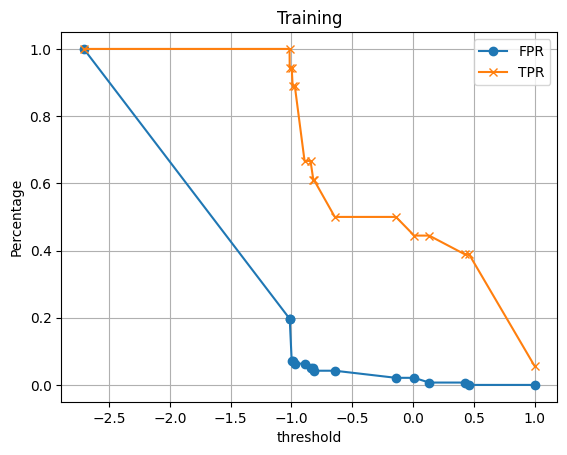

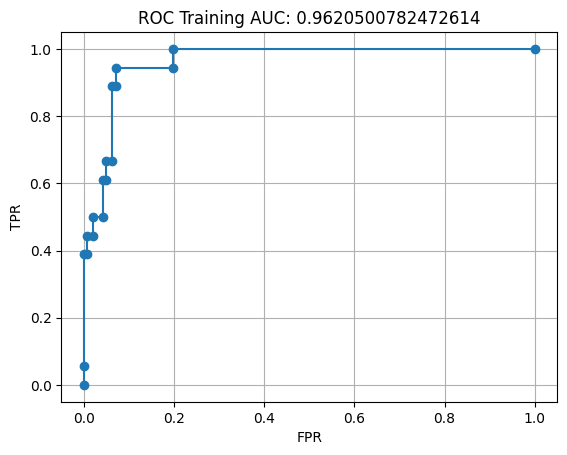

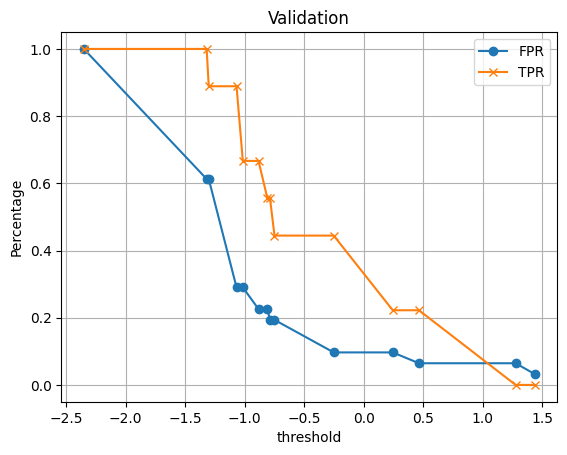

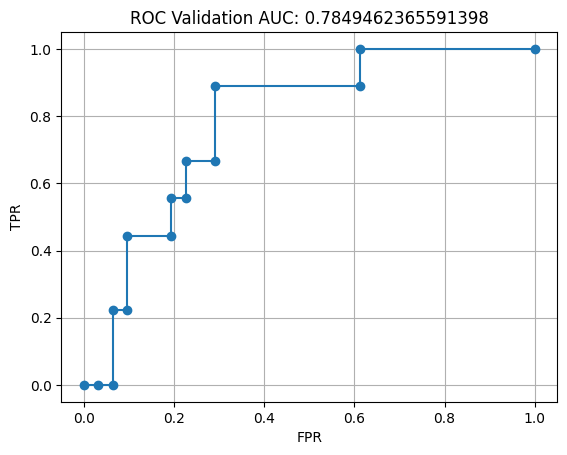

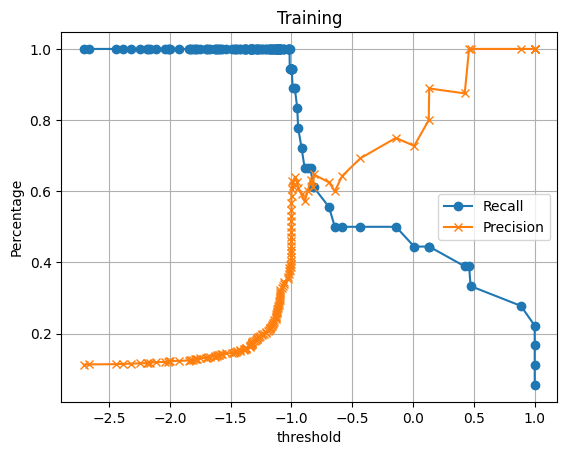

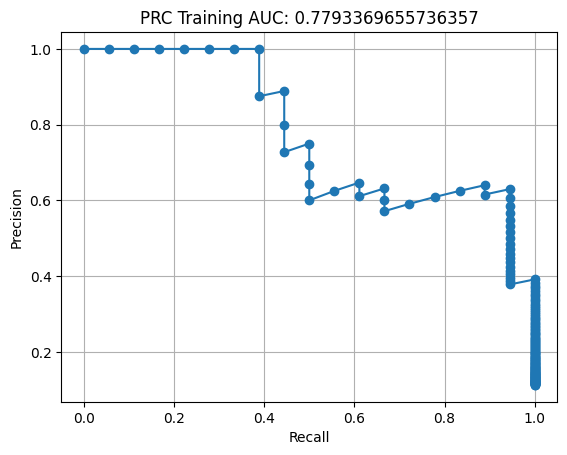

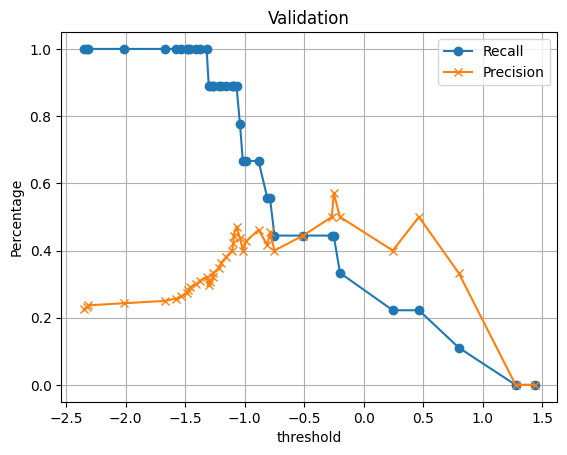

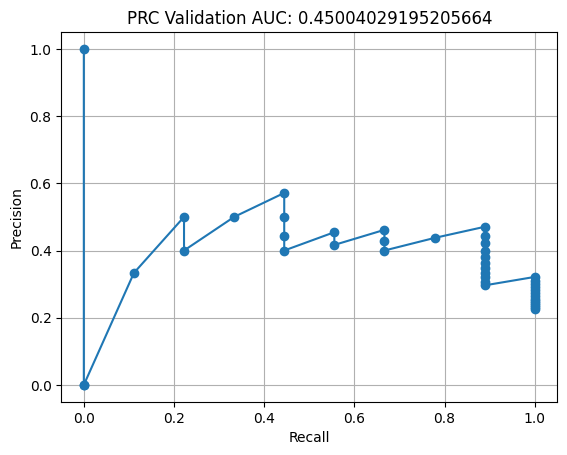

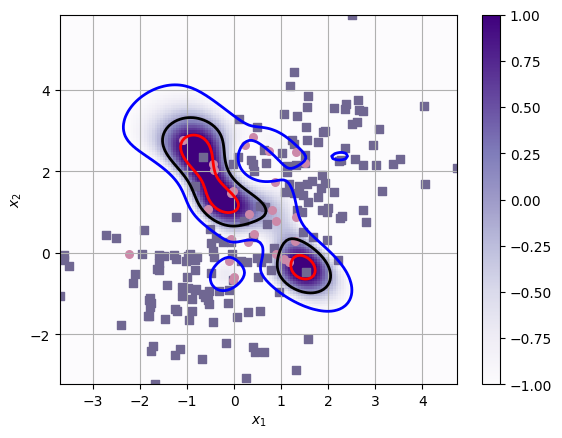

Training AUC ROC: 0.9620500782472614
Validation AUC ROC: 0.7849462365591398


In [7]:

from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
def plotROC(y,z,pstr = ''):
    fpr,tpr,tt = roc_curve(y, z)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(tt,fpr,'o-',tt,tpr,'x-');plt.xlabel('threshold');plt.ylabel('Percentage');plt.legend(['FPR','TPR']);plt.grid();plt.title(pstr)
    plt.figure()
    plt.plot(fpr,tpr,'o-');plt.xlabel('FPR');plt.ylabel('TPR');plt.grid();plt.title('ROC '+pstr+' AUC: '+str(roc_auc))
    return roc_auc

def plotPRC(y,z,pstr = ''):
    P,R,tt = precision_recall_curve(y, z)
    pr_auc = average_precision_score(y, z)
    plt.figure()
    plt.plot(tt,R[:-1],'o-',tt,P[:-1],'x-');plt.xlabel('threshold');plt.ylabel('Percentage');plt.legend(['Recall','Precision']);plt.grid();plt.title(pstr)
    plt.figure()
    plt.plot(R,P,'o-');plt.xlabel('Recall');plt.ylabel('Precision');plt.grid();plt.title('PRC '+pstr+' AUC: '+str(pr_auc))
    return pr_auc

# plot fpr and tpr vs. thrshold and roc
roc_tr = plotROC(y_train,clf.decision_function(X_train),'Training')
roc_v = plotROC(y_val,clf.decision_function(X_val),'Validation')
pr_tr = plotPRC(y_train,clf.decision_function(X_train),'Training')
pr_v = plotPRC(y_val,clf.decision_function(X_val),'Validation')


plt.figure()
plotit(X = X, Y = Y, clf = clf.decision_function, conts =[-1,0,1], colors = 'random')

print('Training AUC ROC:', roc_tr)
print('Validation AUC ROC:', roc_v)


## K-Fold Cross-Validation

Let's perform K-Fold cross-validation. Why is it important to do it in a stratified manner?


Each fold "k" will generate its own ROC curve by generating a list of $FPR_k(t)$ and $TPR_k(t)$ values at different thresholds $t$. As each fold generates different FPR values and corresponding TPR values, we use interpolation to get TPR values for each fold at all FPR values in a given range so that we can average the TPR values to produce a "vertically averaged" ROC Curve.

We then utilize bootstrap estimation to get confidence intervals of the TPR at a given FPR value. What is your interpretation of the confidence interval of the ROC curve?

We use a similar strategy to compute the PR Curves.



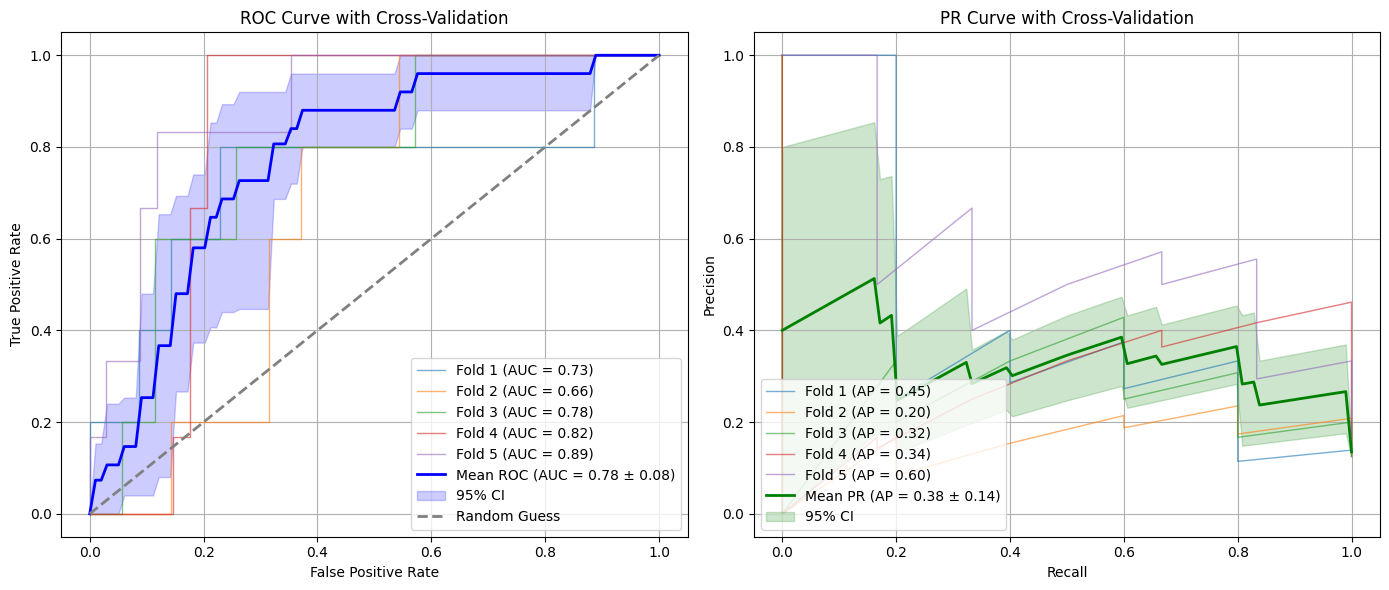

Fold-Wise ROC AUCs: [0.7314285714285714, 0.6628571428571428, 0.7771428571428571, 0.8186274509803921, 0.8872549019607843]
Mean ROC AUC: 0.7751515151515151
Standard Deviation ROC AUC: 0.07613478975033205
Fold-Wise PR APs: [0.4494444444444444, 0.19568519715578536, 0.32058608058608057, 0.33803418803418805, 0.6044973544973544]
Mean PR AP: 0.38164945294357056
Standard Deviation PR AP: 0.13745623253022643


In [8]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Cross-validation and bootstrapping for confidence intervals
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mean_fpr = np.linspace(0, 1, 100)
mean_recall = np.linspace(0, 1, 100)
tprs = []  # For ROC
precisions = []  # For PR
aucs = []  # ROC AUCs
aps = []  # Average Precisions (APs)

# Plot ROC and PR for each fold
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
roc_ax, pr_ax = axes

for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    # Train model
    clf = SVC(C=10.0, kernel='rbf', gamma=1.0, probability=True)
    clf.fit(X_train, y_train)

    # Predict probabilities
    y_score = clf.decision_function(X_test)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0  # Ensure TPR starts at 0
    aucs.append(roc_auc)
    roc_ax.plot(fpr, tpr, lw=1, alpha=0.6, label=f"Fold {i + 1} (AUC = {roc_auc:.2f})")

    # PR Curve
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    precisions.append(np.interp(mean_recall, recall[::-1], precision[::-1]))

    # Use average_precision_score for AP
    ap = average_precision_score(y_test, y_score)
    aps.append(ap)
    pr_ax.plot(recall, precision, lw=1, alpha=0.6, label=f"Fold {i + 1} (AP = {ap:.2f})")

# Calculate mean and confidence intervals for ROC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Bootstrap confidence intervals for ROC
n_bootstraps = 1000
confidence = 0.95
bootstrapped_tprs = []
for i in range(n_bootstraps):
    indices = resample(range(len(tprs)), replace=True, n_samples=len(tprs))
    bootstrapped_tprs.append(np.mean([tprs[idx] for idx in indices], axis=0))

lower_roc = np.percentile(bootstrapped_tprs, (1 - confidence) / 2 * 100, axis=0)
upper_roc = np.percentile(bootstrapped_tprs, (1 + confidence) / 2 * 100, axis=0)

# Calculate mean and confidence intervals for PR
mean_precision = np.mean(precisions, axis=0)
std_precision = np.std(precisions, axis=0)

# Bootstrap confidence intervals for PR
bootstrapped_precisions = []
for i in range(n_bootstraps):
    indices = resample(range(len(precisions)), replace=True, n_samples=len(precisions))
    bootstrapped_precisions.append(np.mean([precisions[idx] for idx in indices], axis=0))

lower_pr = np.percentile(bootstrapped_precisions, (1 - confidence) / 2 * 100, axis=0)
upper_pr = np.percentile(bootstrapped_precisions, (1 + confidence) / 2 * 100, axis=0)

# Plot Mean ROC Curve
roc_ax.plot(mean_fpr, mean_tpr, color='blue', lw=2, label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
roc_ax.fill_between(mean_fpr, lower_roc, upper_roc, color='blue', alpha=0.2, label=f'{int(confidence * 100)}% CI')
roc_ax.plot([0, 1], [0, 1], linestyle="--", color="gray", lw=2, label="Random Guess")
roc_ax.set_xlabel("False Positive Rate")
roc_ax.set_ylabel("True Positive Rate")
roc_ax.set_title("ROC Curve with Cross-Validation")
roc_ax.legend(loc="lower right")
roc_ax.grid()

# Plot Mean PR Curve
pr_ax.plot(mean_recall, mean_precision, color='green', lw=2, label=f'Mean PR (AP = {np.mean(aps):.2f} ± {np.std(aps):.2f})')
pr_ax.fill_between(mean_recall, lower_pr, upper_pr, color='green', alpha=0.2, label=f'{int(confidence * 100)}% CI')
pr_ax.set_xlabel("Recall")
pr_ax.set_ylabel("Precision")
pr_ax.set_title("PR Curve with Cross-Validation")
pr_ax.legend(loc="lower left")
pr_ax.grid()

plt.tight_layout()
plt.show()

print("Fold-Wise ROC AUCs:", aucs)
print("Mean ROC AUC:", mean_auc)
print("Standard Deviation ROC AUC:", std_auc)
print("Fold-Wise PR APs:", aps)
print("Mean PR AP:", np.mean(aps))
print("Standard Deviation PR AP:", np.std(aps))


## Testing

Let's train the model over the training set and the test it on a test set to simulate a deployment scenario. Ideally, we would like the training, validation and test performance metrics to be comparable to ensure good generalization. Here we use our data generation process to generate test examples.

<ipython-input-2-c6cc540527c3>:58: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')


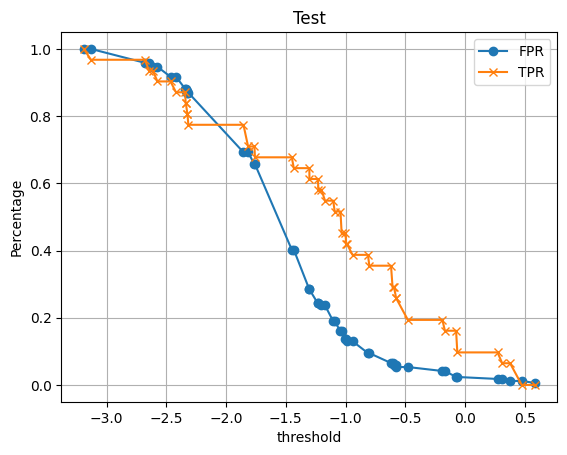

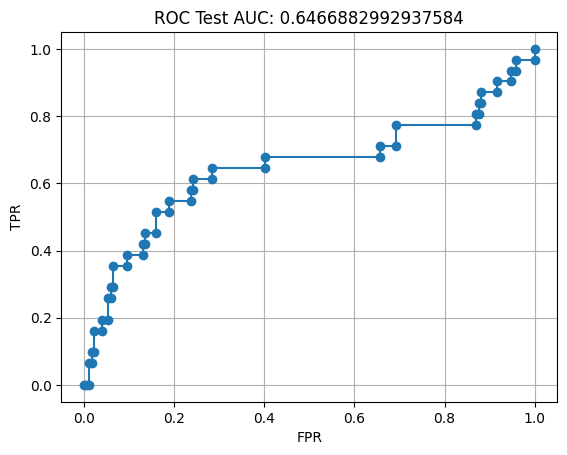

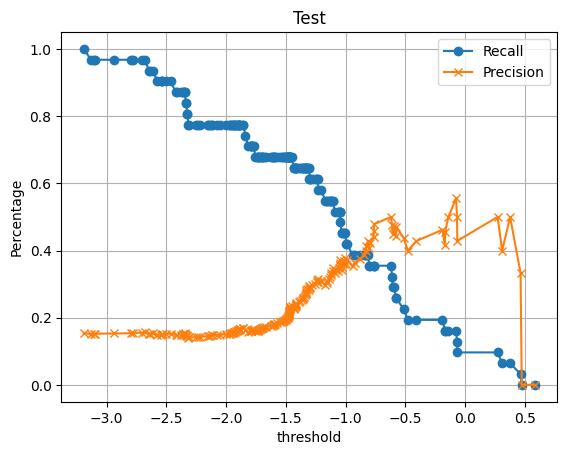

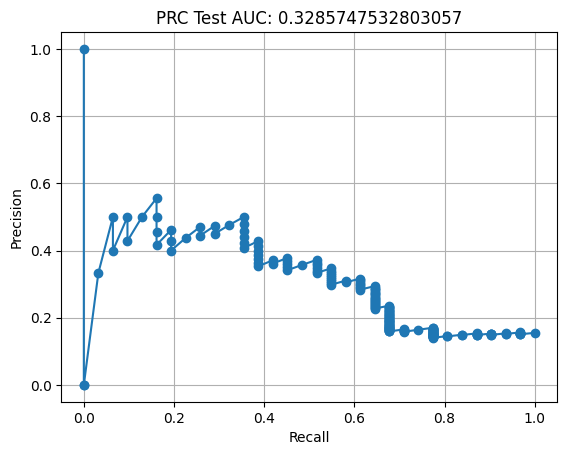

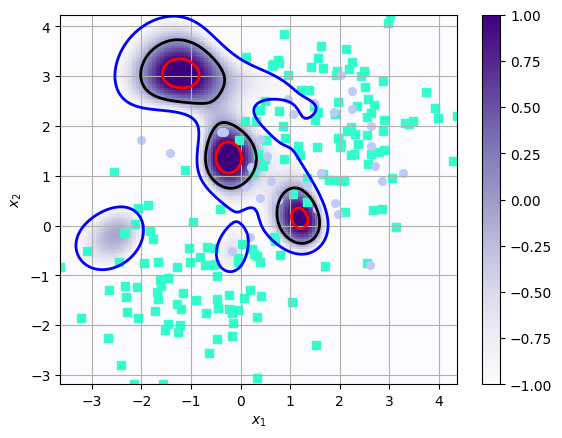

Test AUC ROC: 0.6466882992937584


In [9]:
#Final model training on all data prior to "deployment"
clf = SVC(C=10.0, kernel='rbf',gamma = 1.0).fit(X,Y)
#testing
Xtt, ytt = stream_gen.generate_batch(200) # generating a batch of 200 examples
roc_tt = plotROC(ytt,clf.decision_function(Xtt),'Test')
pr_tt = plotPRC(ytt,clf.decision_function(Xtt), 'Test')
plt.figure()
plotit(X = Xtt, Y = ytt, clf = clf.decision_function, conts =[-1,0,1], colors = 'random')

print('Test AUC ROC:', roc_tt)

## AUCROC and Probability of concordant ranking

The code below uses bootstrap estimation to calculate the probability of a randomly selected positive example to be scored higher than a randomly selected negative example. How does it related to AUC-ROC?

In [10]:
ztt = clf.decision_function(Xtt)
pos_idx, neg_idx = np.where(ytt==1)[0], np.where(ytt!=1)[0]
N_pairs = 10000
sampled_pos_idx = np.random.choice(pos_idx, size=N_pairs, replace=True)
sampled_neg_idx = np.random.choice(neg_idx, size=N_pairs, replace=True)
p = np.mean(ztt[sampled_pos_idx]>ztt[sampled_neg_idx])
print('Probability of a positive example being scored higher than a negative example',p)

Probability of a positive example being scored higher than a negative example 0.6399


## Caveats with PR Curves and their Averaging

Notice that, unlike the "monotonic" relationship between recall and FPR, the relationship between sensitivity and precision is non-monotonous as precision can increase or decrease as sensitivity increases. The eagle-eyed among you must have noticed that, unlike the AUROC (Area Under the Receiver Operating Characteristic curve), where we use the "auc" function to compute the area under the ROC curve, for the Precision-Recall (PR) curve, we often use the "average_precision_score" function instead. This distinction is not arbitrary: it stems from the differences in how these metrics are calculated and what they represent.

While the "auc" function calculates the area under the curve using the trapezoidal rule (which simply integrates the curve regardless of its context), the "average_precision_score" provides a weighted mean of precision across all thresholds, weighted by the increase in recall. This makes "average_precision_score" more reflective of a model's true ability to balance precision and recall, especially in datasets with imbalanced classes or fluctuating precision-recall behavior.

This distinction is crucial because the PR curve is not always smooth or continuous, and the direct application of the "auc" function can overemphasize regions of high recall where precision may significantly drop. The "average_precision_score", on the other hand, focuses on how well the model maintains high precision as recall increases, providing a more robust and meaningful metric for evaluating classification performance in contexts where the positive class is of primary interest.

Consequently, interpreting an averaged precision-recall (PR) curve comes with several caveats and potential pitfalls due to the nature of PR curves and the averaging process. Here's what you need to watch out for:

### Non-Uniform Distribution of Recall Across Folds
* Issue: Recall values are not evenly distributed across PR curves from different cross-validation folds, particularly in datasets with class imbalance. This can lead to interpolated precision values being unrepresentative of the actual performance in certain regions of the curve.
* Impact: The averaged curve might give a misleading impression of model performance if recall points in certain regions are dominated by a few folds with extreme behavior.
* Mitigation: Be cautious about small datasets or datasets with uneven class distributions across folds. Always report both the mean Average Precision (AP) and the averaged PR curve to provide a complete picture.
### The Curve May Not Reflect Actual Threshold-Specific Performance
* Issue: PR curves are derived from thresholds on decision scores, but averaging PR curves across folds (via interpolation) does not correspond to a PR curve that could be produced by any single classifier or threshold.
* Impact: The averaged PR curve might look smoother and better-behaved than the actual performance at any specific threshold or fold.
* Mitigation: Use the average precision score (AP) as a more robust single-number summary that captures the essence of PR performance.

### Sensitivity to Class Imbalance
* Issue: PR curves are heavily influenced by the proportion of positive samples in the dataset. When positive samples are rare (highly imbalanced datasets), even a small number of false positives can drastically lower precision.
* Impact: The averaged PR curve may reflect these fluctuations and appear overly pessimistic in imbalanced datasets, especially at low recall values.
* Mitigation: Compare PR curves with the random guess baseline (horizontal line at the positive class ratio) to contextualize the model's performance.

### Skewed Interpolation in Sparse Regions
* Issue: If precision-recall points are sparse or unevenly distributed (e.g., large gaps between recall values in some folds), interpolation can disproportionately affect certain regions of the averaged curve.
* Impact: The interpolated averaged precision curve may artificially smooth or distort the true behavior of the model in regions with sparse data points.
* Mitigation: Use interpolation carefully, ensuring the fixed recall grid is sufficiently fine-grained (e.g., 100 points between 0 and 1).

### Loss of Threshold Information
* Issue: Averaging PR curves obscures the thresholds used to compute precision and recall. This means you cannot use the averaged PR curve to identify an optimal decision threshold for the classifier.
* Impact: The curve cannot guide decision-making about where to set thresholds for trade-offs between precision and recall.
* Mitigation: Complement the averaged PR curve with per-fold or single-threshold evaluations to inform threshold selection.

### Interpretation Across Models
* Issue: Comparing PR curves between two models can be tricky because the curves are influenced by class distributions and other dataset-specific factors.
* Impact: One model may appear better in regions with high recall but worse in regions with high precision, making direct comparisons difficult.
* Mitigation: Focus on the average precision score (AP) as a single-number summary for comparisons, and analyze PR curves qualitatively for further insights.

### Misleading Confidence Intervals
* Issue: Bootstrapped confidence intervals on the averaged curve may not reflect the full variability of model performance across folds. They represent the uncertainty in the mean curve, not the variability in actual fold-wise curves.
* Impact: A narrow confidence interval on the averaged PR curve might give a false sense of model stability.
* Mitigation: Plot fold-wise PR curves alongside the averaged curve to understand the variability.

### Overemphasis on High Recall or High Precision
* Issue: Depending on the dataset and model, some regions of the PR curve (e.g., low recall with high precision or high recall with low precision) may dominate the averaged curve, potentially skewing its interpretation.
* Impact: The averaged PR curve may not fairly represent the trade-off between precision and recall across all thresholds.
* Mitigation: Interpret the averaged PR curve in conjunction with the AP score, which weights precision by recall.

### No Clear Threshold for Deployment
* Issue: PR curves provide insights into the trade-offs between precision and recall but do not give a direct way to select the best operating threshold for a model in deployment.
* Impact: Deployment decisions may still require further threshold tuning using metrics like F1 score, precision at a specific recall, or cost-sensitive evaluations.
* Mitigation: Use PR curves for understanding model trade-offs but rely on other metrics for threshold selection.

## Best Practices:

* Always Report Average Precision (AP):
The AP score provides a robust, threshold-independent summary of PR performance.
* Complement with Fold-Wise Curves:
Include fold-specific PR curves alongside the averaged curve to visualize variability.
* Contextualize with Random Baseline:
Add the random guess line (positive class ratio) to assess model performance relative to chance.
* Be Transparent About Interpolation:
Specify that the averaged PR curve is interpolated and not directly tied to any single classifier's decision process.
* Compare Models Using AP:
Use the averaged PR curve for qualitative insights and the AP score for quantitative comparisons.

# Questions:

0. What is the difference between training, validation and test examples? What is the goal of using each type of examples?
1. What is stratified validation?
2. What are underlying assumptions for accuracy as a metric?
3. What is precision, recall, false positive rate?
4. Why are accuracy, precision, recall etc. dependent upon the threshold of the classifier?
5. How do precision, recall and false positive rate change as the threshold of the classifier is increased?
6. What is the ROC curve?
7. How does area under the ROC curve serve as a performance metric? How does it relate to the probability that a randomly picked positive example will be scored higher by a classifier than a randomly picked negative example?
8. Why is the ROC curve called the ROC curve?
9. How does the performance estimate of your model change with increase in the size of your validation set?
10. What are the limitations of ROC curves?
11. What is the most important region of an ROC curve?
12. How is a precision recall curve useful?
13. What is the relationship between the ROC and Precision-Recall curves?
14. What are the limitations of the precision recall curve?
15. How do we train the final model for deployment?
16. How can you chose an "operating point" for a machine learning model?
17. Consider a binar classification problem in which the number of negative examples is roughly equal to the number of positive examples. If I use a random classifier (one that generates random scores between -1 and +1 inclusive), what will be the value of each of the following metrics for this classifier (you can choose a threshold of zero for metrics that require a threshold for their computation): Accuracy, Balanced Accuracy, AUC-ROC, AUC-PR, F1, MCC?
18. Consider a binar classification problem in which the number of negative examples is 9 times more than the number of positive examples. If I use a random classifier (one that generates random scores between -1 and +1 inclusive), what will be the value of each of the following metrics for this classifier (you can choose a threshold of zero for metrics that require a threshold for their computation): Accuracy, Balanced Accuracy, AUC-ROC, AUC-PR, F1, MCC?
19. Consider a binar classification problem in which the number of negative examples is roughly equal to the number of positive examples. If I use a  classifier that always predicts a score of 1.0 for any example, what will be the value of each of the following metrics for this classifier (you can choose a threshold of zero for metrics that require a threshold for their computation): Accuracy, Balanced Accuracy, AUC-ROC, AUC-PR, F1, MCC?
20. Consider a binary classification problem in which the number of negative examples is roughly equal to the number of positive examples. If I use a  classifier that always predicts a score of 1.0 for any example, what will be the value of each of the following metrics for this classifier (you can choose a threshold of zero for metrics that require a threshold for their computation): Accuracy, Balanced Accuracy, AUC-ROC, AUC-PR, F1, MCC?
21. Unlike the ROC curve, the PR curve is non-montonous. Why is this the case?
22. How do each of FPR, TPR and precision change as the threshold is increased from very small values to very large values?

# Important Exercise


Note down your observations when using this ipython notebook over an imbalanced machine learning problem
